# Introduction

In [1]:
"""
What? Prediction intervals for Random Forests - Quantile regression forests

Reference: https://blog.datadive.net/prediction-intervals-for-random-forests/
"""

# Prediction vs. confidence interval

In [2]:
"""
A CONFIDENCE interval quantifies the uncertainty on an estimated population variable, such as the mean or 
standard deviation. It can be used to quantify the uncertainty of the estimated skill of a model.

A PREDICTION interval quantifies the uncertainty on a single observation estimated from the population. It
can be used to quantify the uncertainty of a single forecast. 
"""

# Import libraries/modules

In [3]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Dataset

In [4]:
"""
Let’s look at the well-known Boston housing dataset and try to create prediction intervals 
using vanilla random forest from scikit-learn:
"""

'\nLet’s look at the well-known Boston housing dataset and try to create prediction intervals \nusing vanilla random forest from scikit-learn:\n'

In [5]:
boston = load_boston()
X = boston["data"]
Y = boston["target"]
size = len(boston["data"])
print(len(X))

506


In [6]:
"""
We’ll use 400 samples for training, leaving 106 samples for test. The size of the forest 
should be relatively large, so let’s use 1000 trees.
"""

'\nWe’ll use 400 samples for training, leaving 106 samples for test. The size of the forest \nshould be relatively large, so let’s use 1000 trees.\n'

In [7]:
trainsize = 400
idx = list(range(size))
# shuffle the data
np.random.shuffle(idx)

In [8]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1)
rf.fit(X[idx[:trainsize]], Y[idx[:trainsize]])

RandomForestRegressor()

# Quantile regression forests

In [9]:
"""
A general method for finding confidence intervals for decision tree based methods is Quantile 
Regression Forests. The idea: instead of recording the mean value of response variables in each tree leaf in 
the forest, record all observed responses in the leaf.  The prediction can then return not just the mean of 
the response variables, but the full conditional distribution P(Y≤y∣X=x) of response values for every x. 
Using the distribution, it is trivial to create prediction intervals for new instances simply by using the 
appropriate percentiles of the distribution. For example, the 95% prediction intervals would be the range 
between 2.5 and 97.5 percentiles of the distribution of the response variables in the leaves.
"""

'\nA general method for finding confidence intervals for decision tree based methods is Quantile \nRegression Forests. The idea: instead of recording the mean value of response variables in each tree leaf in \nthe forest, record all observed responses in the leaf.  The prediction can then return not just the mean of \nthe response variables, but the full conditional distribution P(Y≤y∣X=x) of response values for every x. \nUsing the distribution, it is trivial to create prediction intervals for new instances simply by using the \nappropriate percentiles of the distribution. For example, the 95% prediction intervals would be the range \nbetween 2.5 and 97.5 percentiles of the distribution of the response variables in the leaves.\n'

In [10]:
"""
But here’s a nice thing: one can use a random forest as quantile regression forest simply by expanding the tree 
fully so that each leaf has exactly one value. (And expanding the trees fully is in fact what Breiman suggested 
in his original random forest paper.) Then a prediction trivially returns individual response variables from 
which the distribution can be built if the forest is large enough. One caveat is that expanding the tree fully 
can overfit: if that does happen, the intervals will be useless, just as the predictions. The nice thing is that 
just like accuracy and precision, the intervals can be cross-validated.
"""

'\nBut here’s a nice thing: one can use a random forest as quantile regression forest simply by expanding the tree \nfully so that each leaf has exactly one value. (And expanding the trees fully is in fact what Breiman suggested \nin his original random forest paper.) Then a prediction trivially returns individual response variables from \nwhich the distribution can be built if the forest is large enough. One caveat is that expanding the tree fully \ncan overfit: if that does happen, the intervals will be useless, just as the predictions. The nice thing is that \njust like accuracy and precision, the intervals can be cross-validated.\n'

In [11]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    err_mean = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:

            # preds.append(pred.predict(X[x])[0])
            # We need to reshape because it considers a single samlep
            #print(pred.predict(X[x].reshape(1, -1)))
            preds.append(pred.predict(X[x].reshape(1, -1)))

        err_down.append(np.percentile(preds, (100 - percentile) / 2.))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
        err_mean.append(np.mean(preds))
    return err_down, err_up, err_mean

In [12]:
"""
Let’s compute 90% prediction intervals and test how many observations in the test set fall 
into the interval.
"""

'\nLet’s compute 90% prediction intervals and test how many observations in the test set fall \ninto the interval.\n'

In [13]:
print(trainsize)
print(len(X[idx[trainsize:]]))
err_down, err_up, err_mean = pred_ints(rf, X[idx[trainsize:]], percentile=90)


truth = Y[idx[trainsize:]]
correct = 0.
for i, val in enumerate(truth):
    if err_down[i] <= val <= err_up[i]:
        correct += 1
print(correct/len(truth))

400
106
0.8867924528301887


In [14]:
"""
This is pretty close to what we expected: 90.6% of observations fell into the prediction 
intervals. Plotting the true values and predictions together with error bars visualizes this
nicely.
"""

'\nThis is pretty close to what we expected: 90.6% of observations fell into the prediction \nintervals. Plotting the true values and predictions together with error bars visualizes this\nnicely.\n'

# Plot

In [15]:
df = pd.DataFrame()
df['v'] = truth
df['p_d'] = err_down
df['p_u'] = err_up
df['p'] = err_mean

Text(0, 0.5, 'Response value')

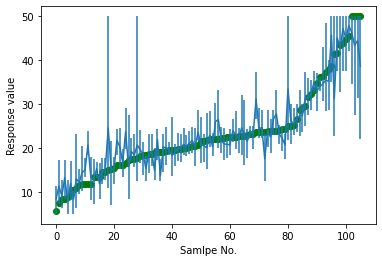

In [16]:
a = df.sort_values(['v']).reset_index()
plt.scatter(a.index, a.v, color='green')
plt.errorbar(a.index, a.p, yerr=[a.p - a.p_d, a.p_u - a.p])
plt.xlabel("Samlpe No.")
plt.ylabel("Response value")

In [17]:
"""
What can also be observed on the plot that on average, predictions that are more accurate 
have smaller prediction intervals since these are usually “easier” predictions to make.
"""

'\nWhat can also be observed on the plot that on average, predictions that are more accurate \nhave smaller prediction intervals since these are usually “easier” predictions to make.\n'

#  A warning

In [18]:
"""
And again, just as one can and should use cross-validation for estimating the accuracy of the model, one should also
cross-validate the intervals to make sure that they give unbiased results on the particular dataset at hand. And just
like one can do probability calibration, interval calbiration can also be done.
"""

'\nAnd again, just as one can and should use cross-validation for estimating the accuracy of the model, one should also\ncross-validate the intervals to make sure that they give unbiased results on the particular dataset at hand. And just\nlike one can do probability calibration, interval calbiration can also be done.\n'

# Batch prediction

In [19]:
"""
I modified your code to do batch predictions instead of iterating over each sample:
"""

'\nI modified your code to do batch predictions instead of iterating over each sample:\n'

In [22]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    preds = []
    for pred in model.estimators_:
        preds.append(pred.predict(X))
        preds = np.vstack(preds).T
    err_down = np.percentile(
        preds, (100 - percentile) / 2., axis=1, keepdims=True)
    err_up = np.percentile(preds, 100 – (100 – percentile) / 2., axis=1, keepdims=True)
    return err_down.reshape(-1,), err_up.reshape(-1,)

SyntaxError: invalid character in identifier (<ipython-input-22-1bcb23222fe8>, line 9)